# Burgers Equation on FLRW Spacetimes
## A Numerical Approach

===== ===== ===== ===== =====

General Burgers: $u_{t} + u\cdot u_{x} - \alpha\cdot u_{xx} = 0$, *where $\alpha =$ diffusion coefficient, and $\alpha = 0$ for Inviscid Burgers*.  Thus,

$u_{t} + u\cdot u_{x} = 0$

On an FLRW background, via Ceylon et al.:

### $a\cdot u_{t}+(1-kr^{2})^{1/2}\cdot \partial_r(\frac{u^2}{2}) + u\cdot (1-\frac{u^{2}}{c^{2}})\cdot \dot{a} = 0$

===== ===== ===== ===== =====
#### Contents:
- Imports
1. Initial Conditions (user configurable)
2. Support Functions (advanced)
3. Main Functions (advanced)
4. Data Collection (user configurable)
5. Plotting (user configurable)

### Library Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

from godunov_burgers import PDE_plotter_1D as Pplot

In [3]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Function
def u_0_x(x):
    if x < .3:
        return 0
    else:
        return 1

# FLRW Acceleration Terms - First Order
def a_scale(t, alpha, a0=1, t0=1):
    return 1 + t**alpha

def a_scale_t(t, alpha, a0=1, t0=1):
    return alpha * t**(alpha - 1)

# Function to calculate the flux
def calculate_flux(u, r, k, a_t):
    return (1 - k * r**2)**0.5 * u**2 / (2 * a_t)

# Function to calculate wave speeds
def calculate_wave_speeds(u, r, k, c, a, a_t):
    wave_speed_1 = abs((1 - k * r**2)**0.5 * u / a)
    wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
    return wave_speed_1, wave_speed_2

# Precompute the maximum wave speeds over the domain and time interval
def precompute_max_wave_speed(u_initial, r, k, c, a_scale, a_scale_t, alpha, t_max):
    max_speed = 0
    t_values = np.linspace(0, t_max, 100)  # Discretize the time interval

    for t in t_values:
        a = a_scale(t,alpha)
        a_t = a_scale_t(t,alpha)
        for i in range(len(u_initial)):
            wave_speed_1, wave_speed_2 = calculate_wave_speeds(u_initial[i], r[i], k, c, a, a_t)
            max_speed = max(max_speed, wave_speed_1, wave_speed_2)

    return max_speed

# Define the HLL flux calculation with correct r interface handling
def hll_flux(u_left, u_right, r_left, r_right, k, a, a_t):
    r_interface = (r_left + r_right) / 2
    f_left = calculate_flux(u_left, r_interface, k, a_t)
    f_right = calculate_flux(u_right, r_interface, k, a_t)
    s_left, s_right = calculate_wave_speeds(u_left, r_interface, k, c, a, a_t)
                      
    if s_left >= 0:
        return f_left
    elif s_right <= 0:
        return f_right
    else:
        return (s_right * f_left - s_left * f_right + s_left * s_right * (u_right - u_left)) / (s_right - s_left)

# Godunov scheme implementation with time-dependent a and a_dot
def godunov_scheme(u0, r, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max):
    U = []
    U.append(u0)
    u = u0.copy()
    t = 0
    while t < t_max + dt:
        t += dt
        u_new = u.copy()

        for i in range(1, len(u) - 1):
            r_left = r[i - 1]
            r_center = r[i]
            r_right = r[i + 1]

            F_i_plus_1_2 = hll_flux(u[i], u[i + 1], r_center, r_right, k, a_scale(t, alpha), a_scale_t(t,alpha))
            F_i_minus_1_2 = hll_flux(u[i - 1], u[i], r_left, r_center, k, a_scale(t, alpha), a_scale_t(t,alpha))

            source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
            u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
                
        u = u_new.copy()
        
        U.append(u)
    
    return U

#### ----

In [4]:
t_max = 1
L = 1
dr = .05
Nr = int(L/dr)
r_grid = np.linspace(0,L,Nr+1)

# Using Initial Conditions, Create u0 (needs u_0_x)
u0 = [u_0_x(r) for r in r_grid]

# Set the boundary conditions
u0[0] = u_t_0(0)
u0[-1] = u_t_L(1)

#### ----

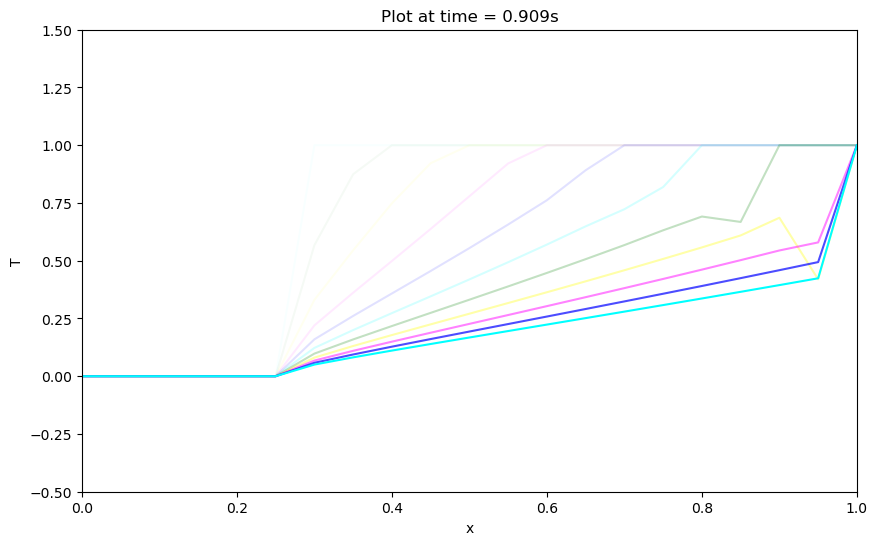

dt = 0.05


In [6]:
k = 0
c = 1
alpha = .5

max_speed = precompute_max_wave_speed(u0, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
dt = dr / max_speed

U = godunov_scheme(u0, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)
Pplot(U, L, t_max, 10, 0, t_max, 0, L, style = 'multi', alpha_decay = .7)

print('dt =',dt)

-----

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Function
def u_0_x(x):
    if x < .3:
        return 0
    else:
        return 1

# FLRW Acceleration Terms - First Order
def a_scale(t, alpha, a0=1, t0=1):
    return 1 + t**alpha

def a_scale_t(t, alpha, a0=1, t0=1):
    return alpha * t**(alpha - 1)

In [ ]:
# Function to calculate the flux
def calculate_flux(u, r, k, a_t):
    return (1 - k * r**2)**0.5 * u**2 / (2 * a_t)

# Function to calculate wave speeds
def calculate_wave_speeds(u, r, k, c, a, a_t):
    wave_speed_1 = abs((1 - k * r**2)**0.5 * u / a)
    wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
    return wave_speed_1, wave_speed_2

# Precompute the maximum wave speeds over the domain and time interval
def precompute_max_wave_speed(u_initial, r, k, c, a_scale, a_scale_t, alpha, t_max):
    max_speed = 0
    t_values = np.linspace(0, t_max, 100)  # Discretize the time interval

    for t in t_values:
        a = a_scale(t,alpha)
        a_t = a_scale_t(t,alpha)
        for i in range(len(u_initial)):
            wave_speed_1, wave_speed_2 = calculate_wave_speeds(u_initial[i], r[i], k, c, a, a_t)
            max_speed = max(max_speed, wave_speed_1, wave_speed_2)

    return max_speed

In [ ]:
L = 1
dr = .05
Nr = int(L/dr)
r_grid = np.linspace(0,L,Nr+1)

In [ ]:
# Using Initial Conditions, Create u0 (needs u_0_x)
u0 = [u_0_x(x) for x in r_grid]

# Set the boundary conditions
u0[0] = u_t_0(0)
u0[-1] = u_t_L(1)

u0

In [ ]:
k = 0
c = 1
alpha = 1
t_max = 1

max_speed = precompute_max_wave_speed(u0, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
dt = dr / max_speed

In [ ]:
# Define the HLL flux calculation with correct r interface handling
def hll_flux(u_left, u_right, r_left, r_right, k, a, a_t):
    r_interface = (r_left + r_right) / 2
    f_left = calculate_flux(u_left, r_interface, k, a_t)
    f_right = calculate_flux(u_right, r_interface, k, a_t)
    s_left, s_right = calculate_wave_speeds(u_left, r_interface, k, c, a, a_t)
                      
    if s_left >= 0:
        return f_left
    elif s_right <= 0:
        return f_right
    else:
        return (s_right * f_left - s_left * f_right + s_left * s_right * (u_right - u_left)) / (s_right - s_left)

# Godunov scheme implementation with time-dependent a and a_dot
def godunov_scheme(u0, r, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max):
    U = []
    U.append(u0)
    u = u0.copy()
    t = 0
    while t < t_max:
        t += dt
        u_new = u.copy()

        for i in range(1, len(u) - 1):
            r_left = r[i - 1]
            r_center = r[i]
            r_right = r[i + 1]

            F_i_plus_1_2 = hll_flux(u[i], u[i + 1], r_center, r_right, k, a_scale(t, alpha), a_scale_t(t,alpha))
            F_i_minus_1_2 = hll_flux(u[i - 1], u[i], r_left, r_center, k, a_scale(t, alpha), a_scale_t(t,alpha))

            source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
            u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
                
        u = u_new.copy()
        
        U.append(u)
    
    return U

In [ ]:
U = godunov_scheme(u0, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)

In [ ]:
steps = 20
t_min_plot = 0
t_max_plot = t_max
x_min_plot = 0
x_max_plot = L

Pplot(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style = 'multi', alpha_decay = .7)